In [ ]:
%cd ../../..

In [21]:
import os
import torch
import numpy as np
import pickle
import matplotlib.pyplot as plt
import smart_settings

from mbrl import allogger
from mbrl.models import forward_model_from_string
from mbrl.environments import env_from_string
from mbrl import torch_helpers
from mbrl.controllers.abstract_controller import OpenLoopPolicy
from mbrl.rolloutbuffer import RolloutBuffer

device = torch.device("cpu")
torch_helpers.device = device

In [3]:
def load_model(path, checkpoint_suffix, env):
    params = smart_settings.load(os.path.join(path, 'settings.json'), make_immutable=False)
    print(params.forward_model)
    forward_model = forward_model_from_string(params.forward_model)(
            env=env, **params.forward_model_params
        )
    forward_model.load(os.path.join(path, 'checkpoints' + checkpoint_suffix, 'forward_model'), for_training=False)
    
    return forward_model

In [4]:
def load_buffer(path):
    rollouts = []
    with open(path, 'rb') as f:
        rollouts.extend(pickle.load(f)[:])
    rollout_buffer = RolloutBuffer(rollouts=rollouts)
    
    return rollout_buffer

In [5]:
allogger.basic_configure(logdir='/tmp/test', default_outputs=['hdf'],
                         hdf_writer_params=dict(min_time_diff_btw_disc_writes=1))

In [6]:
eval_buffer = load_buffer("datasets/playground/rollouts_eval")

In [7]:
working_dir = "results/cee_us/playground/gnn_ensemble_cee_us_freeplay"

In [8]:
params = smart_settings.load(os.path.join(working_dir, 'settings.json'), make_immutable=False)
env = env_from_string(params.env, **params["env_params"])

In [9]:
ensemble_model = load_model(
    working_dir,
    "_249",
    env
)

ParallelGNNDeterministicEnsemble


# Evaluate

In [10]:
def evaluate(buffer, rollout_id, start_idx, horizon, model):
    start_obs = torch.from_numpy(buffer[rollout_id]['observations'][start_idx][None,...]).float().to(device)
    action_sequence = torch.from_numpy(buffer[rollout_id]['actions'][start_idx:start_idx+horizon][None,...]).float().to(device)

    with torch.no_grad():
        policy = OpenLoopPolicy(action_sequence)
        out = model.predict_n_steps(start_observations=start_obs, start_states=None, policy=policy, horizon=horizon)[0]

    return out, buffer[rollout_id]['observations'][start_idx:start_idx+horizon]

In [11]:
predictions, gt_states = evaluate(
    buffer=eval_buffer,
    rollout_id=2,
    start_idx=130, 
    horizon=50,
    model=ensemble_model,
)

In [12]:
# predictions['next_observations'].shape: [1, 5, 50, 48]
horizon_imagination = predictions["next_observations"].shape[-2]

In [13]:
entity_id = {
    'cube_green': 0,
    'cube_pink': 1,
    'cylinder': 2,
    'pyramid': 3,
}
obj_i = np.arange(4,28,6)

In [14]:
plt.style.use('experiments/cee_us/hooks/post_rollout_hooks/prettyplots.mplstyle')
colors = [(0.368, 0.507, 0.71), (0.881, 0.611, 0.142), (0.923, 0.386,0.209),
          (0.56, 0.692, 0.195),(0.528, 0.471, 0.701), (0.772, 0.432,0.102),
          (0.572, 0.586, 0.) ]

In [15]:
save_fig = False
output_path = ""

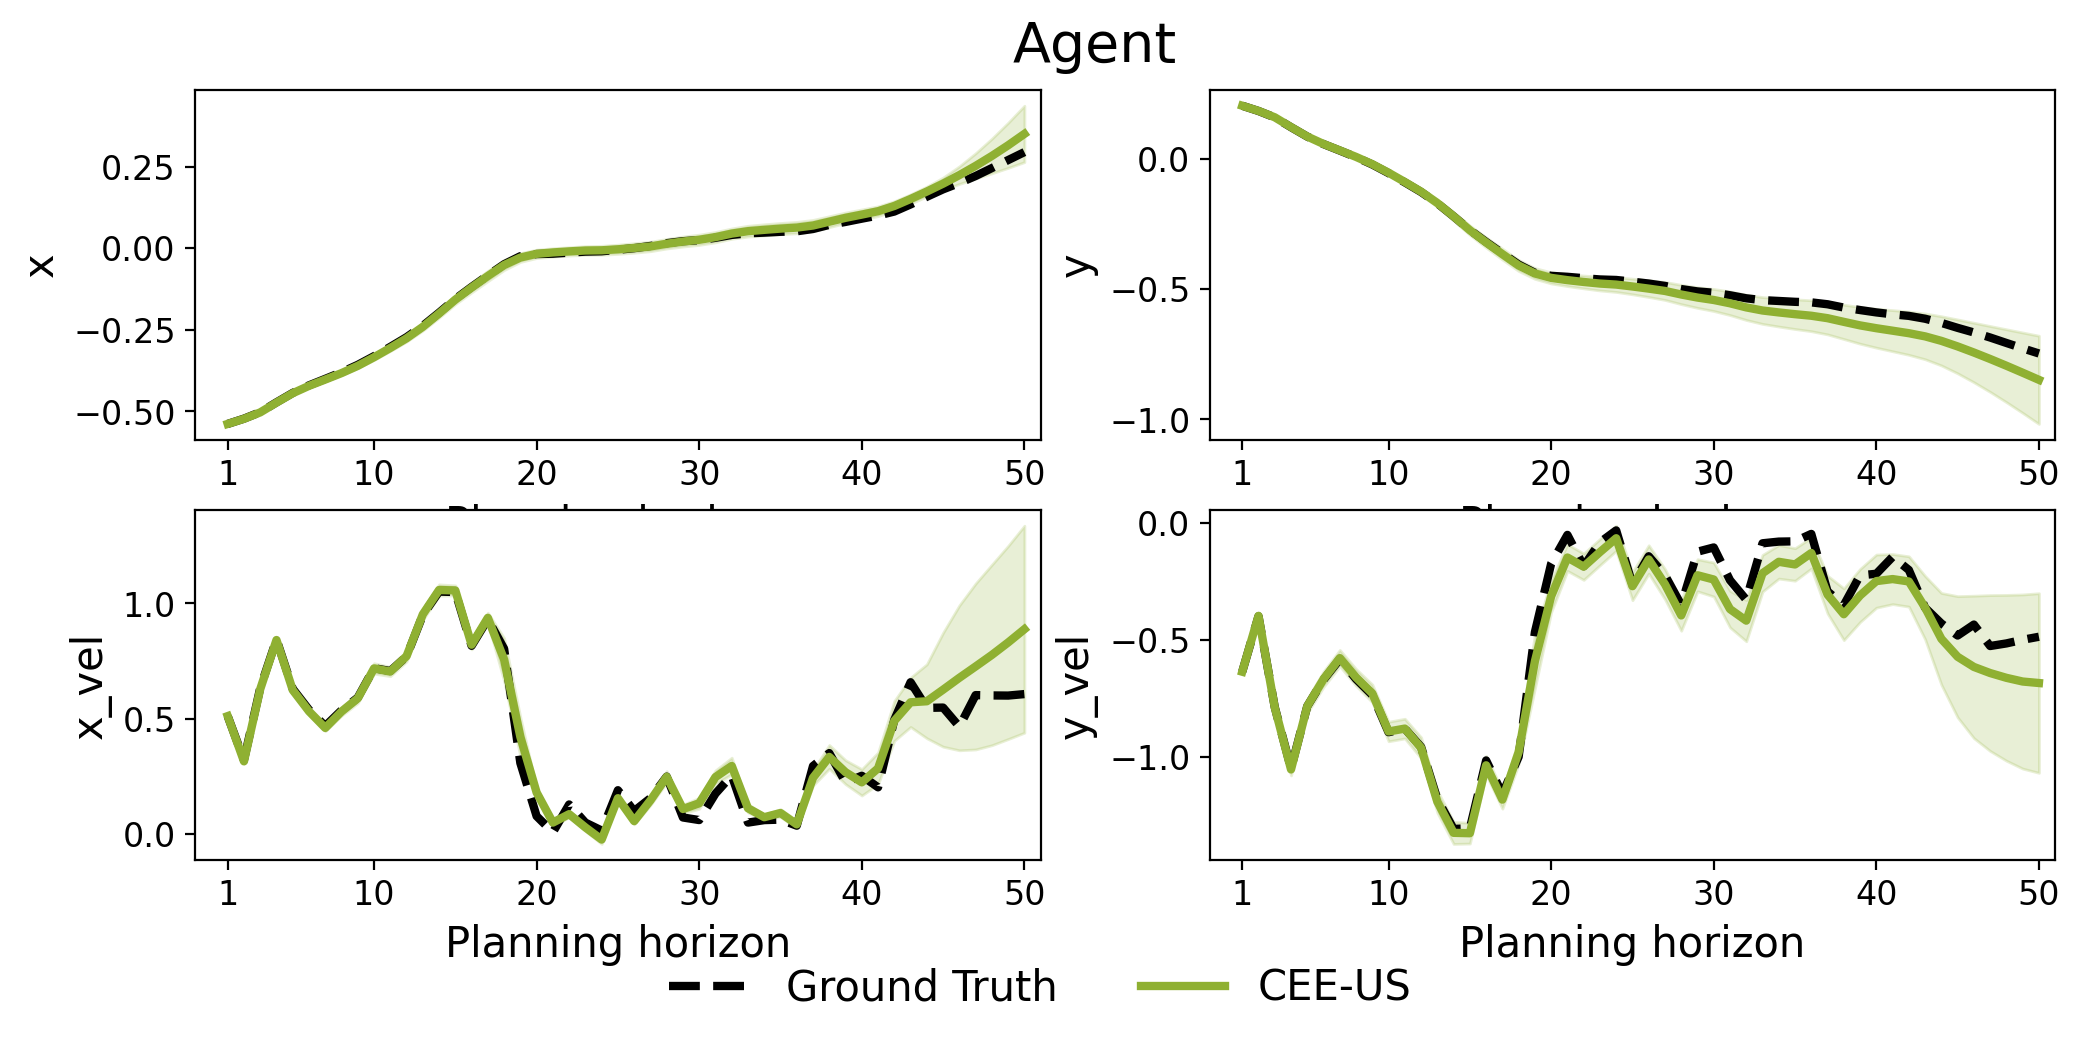

In [16]:
chosen_entity = 'agent'
feature_names_agent = ['x', 'y','x_vel', 'y_vel']

cols = 2
rows = int(np.ceil(len(feature_names_agent) / cols))

t_lim = horizon_imagination
x = np.arange(1,t_lim+1)

start_ind = 0

fig, axs = plt.subplots(rows,cols,figsize=(12,5))


for k, ax in enumerate(axs.flatten()):    

    ax.plot(x, gt_states[:, start_ind+k], color='black', linestyle="--", label="Ground Truth")


    pred_mean = np.mean(predictions['observations'][0,:,:,start_ind+k].cpu().detach().numpy(),0)
    pred_std = np.std(predictions['observations'][0,:,:,start_ind+k].cpu().detach().numpy(),0)

    ax.plot(x,pred_mean, color=colors[3], label="CEE-US")
    ax.fill_between(x, pred_mean-pred_std, pred_mean+pred_std, alpha = 0.2, color=colors[3])

    if k == 4: break

    ax.set_xticks(np.concatenate([np.ones(1,), np.arange(10,t_lim+1,10)]))

    ax.set_xlim([-1,t_lim+1])

    vals = ax.get_yticks()

    ax.set_ylabel(feature_names_agent[k])
    ax.set_xlabel("Planning horizon")


# Put a legend below current axis
lgd = plt.legend(loc='upper center', bbox_to_anchor=(-0.20, -0.20),
          fancybox=True, shadow=False, ncol=4, frameon=False)

text = fig.suptitle("Agent", y=".95")

if save_fig:
    fig.savefig(os.path.join(output_path, "predictions_agent.png"),
               bbox_extra_artists=(lgd,text), bbox_inches='tight')

In [17]:
chosen_entity = 'cylinder'

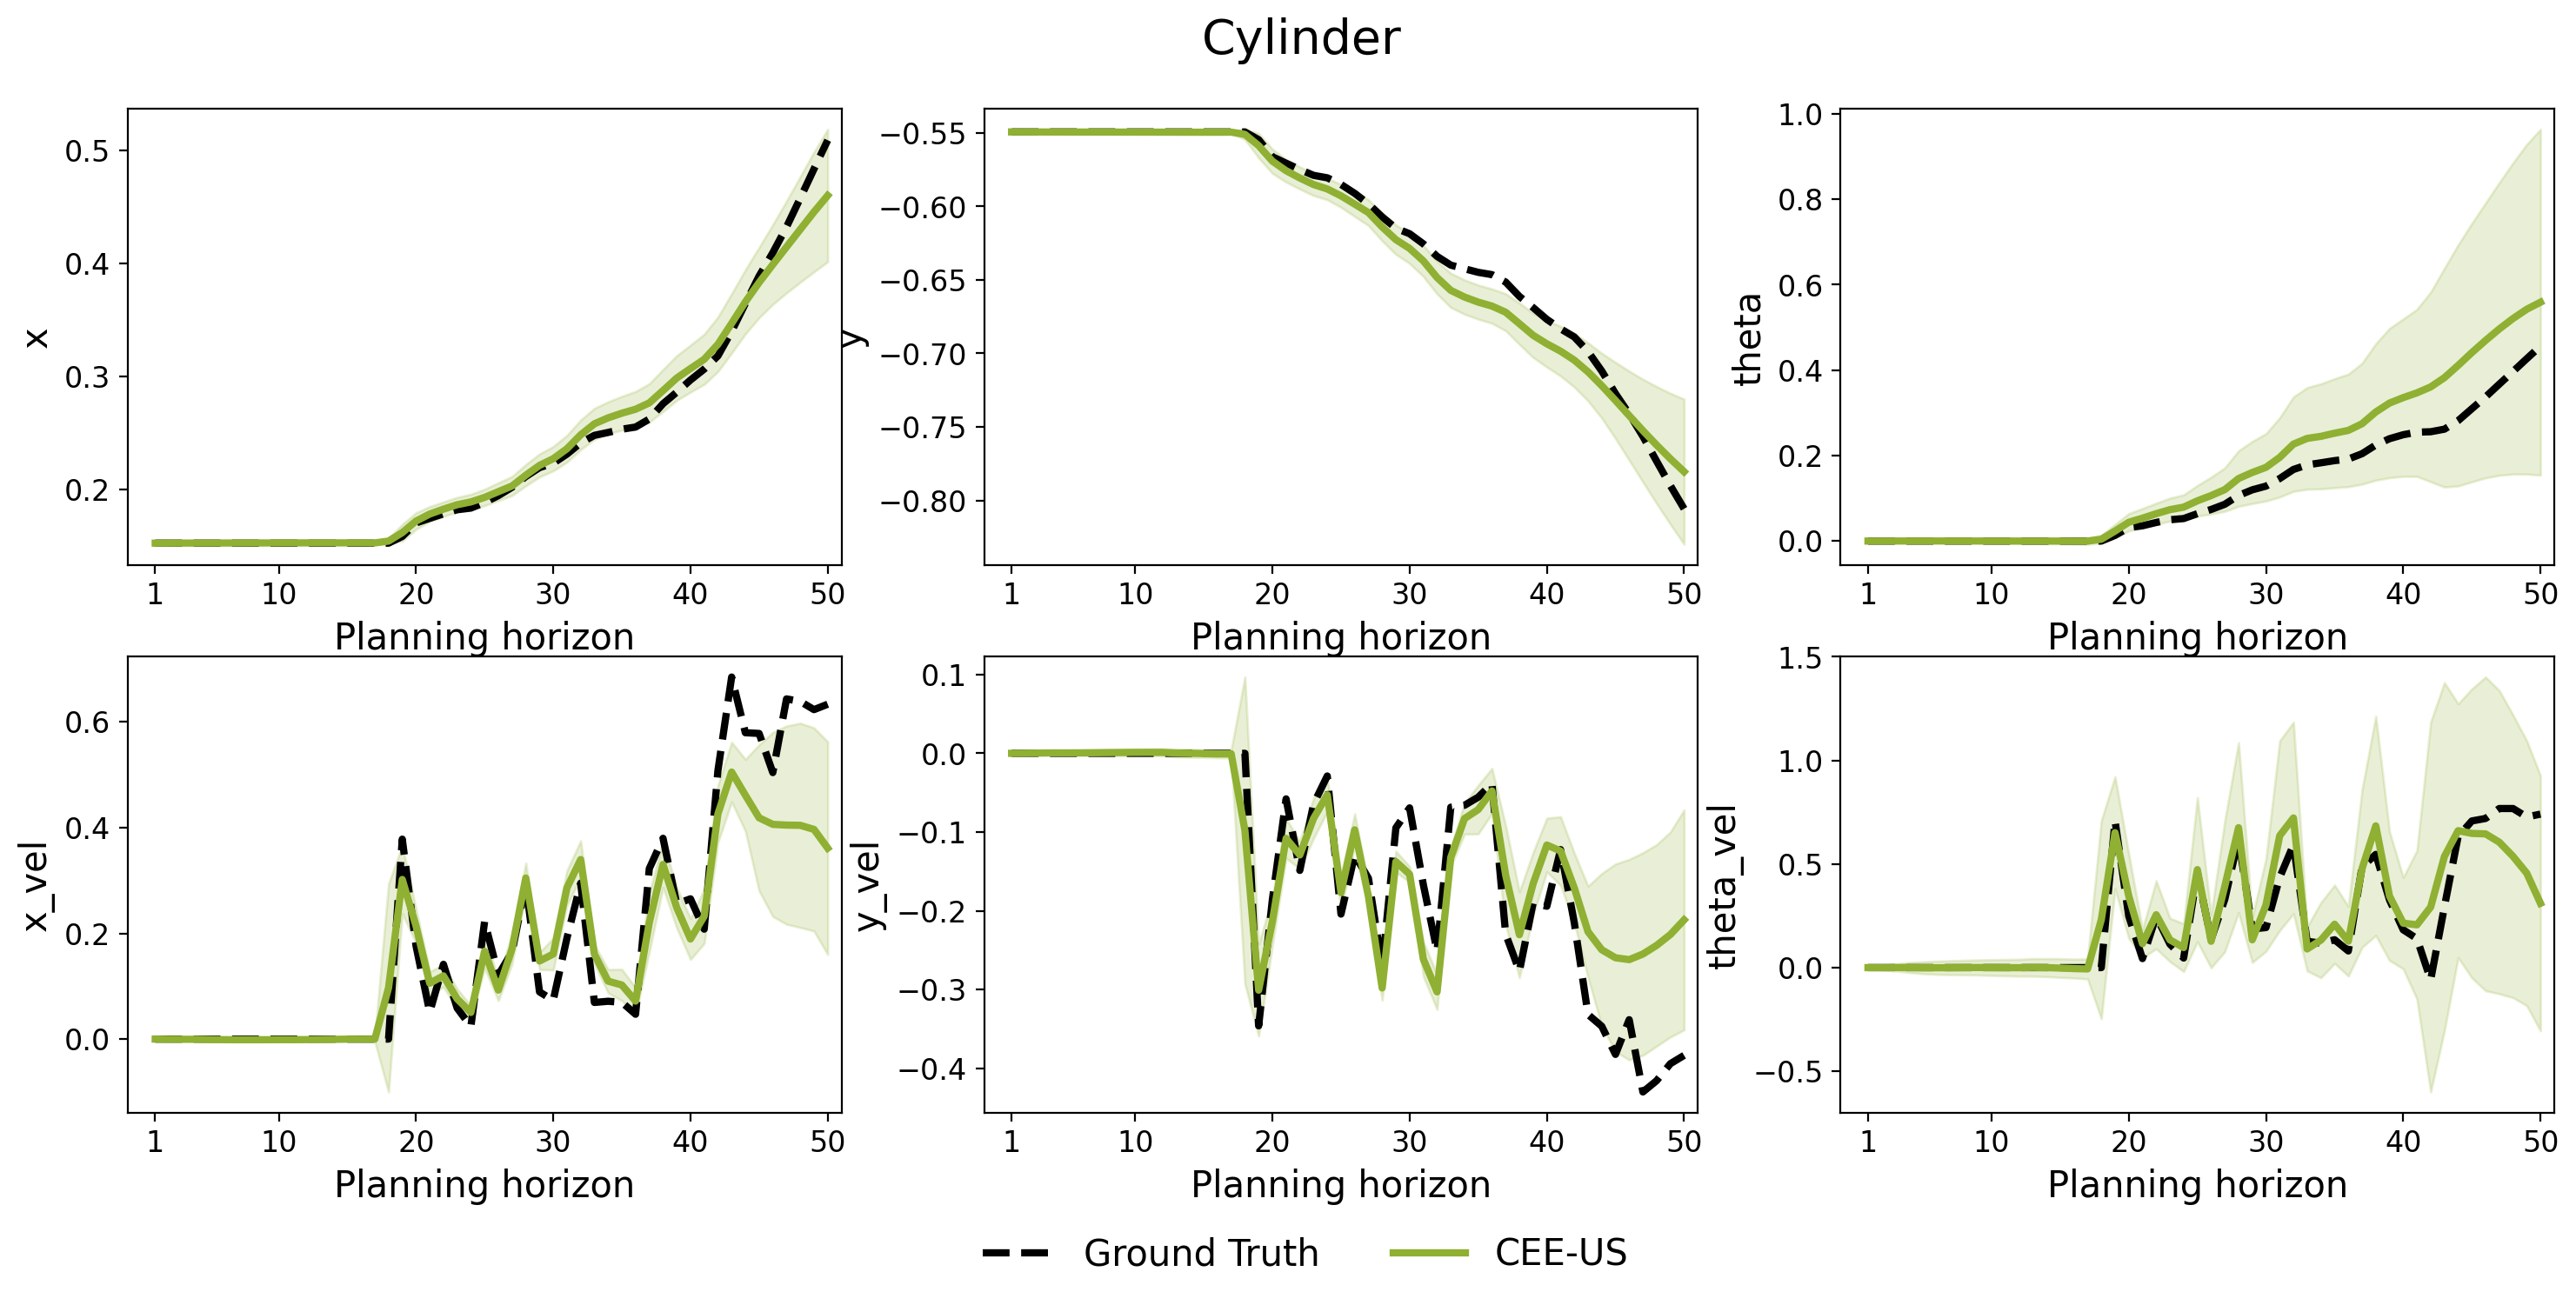

In [18]:
feature_names = ['x', 'y', 'theta','x_vel', 'y_vel', 'theta_vel']

cols = 3
rows = int(np.ceil(len(feature_names) / cols))

t_lim = horizon_imagination
x = np.arange(1,t_lim+1)

chosen_obj_ind = entity_id[chosen_entity]
start_ind = obj_i[chosen_obj_ind]

fig, axs = plt.subplots(rows,cols,figsize=(18,7.5))


for k, ax in enumerate(axs.flatten()):    

    ax.plot(x, gt_states[:, start_ind+k], color='black', linestyle="--", label="Ground Truth")


    pred_mean = np.mean(predictions['observations'][0,:,:,start_ind+k].cpu().detach().numpy(),0)
    pred_std = np.std(predictions['observations'][0,:,:,start_ind+k].cpu().detach().numpy(),0)

    ax.plot(x,pred_mean, color=colors[3], label="CEE-US")
    ax.fill_between(x, pred_mean-pred_std, pred_mean+pred_std, alpha = 0.2, color=colors[3])

    if k == 6: break

    ax.set_xticks(np.concatenate([np.ones(1,), np.arange(10,t_lim+1,10)]))

    ax.set_xlim([-1,t_lim+1])

    vals = ax.get_yticks()

    ax.set_ylabel(feature_names[k])
    ax.set_xlabel("Planning horizon")


# Put a legend below current axis
lgd = plt.legend(loc='upper center', bbox_to_anchor=(-0.75, -0.20),
          fancybox=True, shadow=False, ncol=4, frameon=False)

text = fig.suptitle(chosen_entity.capitalize(), y=".95")

if save_fig:
    fig.savefig(os.path.join(output_path, "predictions_{}.png".format(chosen_entity)),
               bbox_extra_artists=(lgd,text), bbox_inches='tight')

## Replay and visualize the ground truth and model outputs in mujoco:

### Ground Truth:

In [19]:
episode_length = gt_states.shape[0]

obs = env.reset()    
for t in range(episode_length):
    env.set_state_from_observation(gt_states[t, :])
    env.render()    

env.close()

### Model Predictions:

In [20]:
model_outputs = predictions['observations'].cpu().detach().numpy()
episode_length = model_outputs.shape[2]

obs = env.reset()    
for i in range(ensemble_model.ensemble_size):
    for t in range(episode_length):
        env.set_state_from_observation(model_outputs[0,i,t,:])
        env.render()    

env.close()